In [51]:
import h5py as hp
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sbs
from SOLEILII_parameters.SOLEILII_CDR_parameters import *

def read_bunch(bunch_number, n_macroparticles):
    # filename = '/home/gubaidulin/SOLEIL-II/Code/fbii_pyht_tracking/Results_sumo/BM_(n_bunch={0:}, n_macro={1:.1e}).h5'.format(int(bunch_number), n_macroparticles)
    filename = '/home/gubaidulin/scripts/fbii_pyht_tracking/Results_sumo/BM_(n_bunch={0:}, n_macro={1:.1e}, n_macro_ions={2:.1e}).h5'.format(bunch_number, n_macroparticles, 1e4)
    filename = 'Results/BM_n={0:}.h5'.format(bunch_number)
    file = hp.File(filename)
    mean_x = file['Bunch']['mean_x'][:]
    sigma_x = file['Bunch']['sigma_x'][:]
    mean_xp = file['Bunch']['mean_xp'][:]
    mean_y = file['Bunch']['mean_y'][:]
    sigma_y = file['Bunch']['sigma_y'][:]
    mean_yp = file['Bunch']['mean_yp'][:]
    mean_z = file['Bunch']['mean_z'][:]
    mean_dp = file['Bunch']['mean_dp'][:]
    file.close()
    return mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp

In [52]:
# n_macroparticles = int(1e5)
# fig, ax = plt.subplots(1, 1)
# for bunch_number in range(415):
#     mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp = read_bunch(bunch_number, n_macroparticles)
#     ax.scatter(bunch_number, mean_x[-1], marker='.', color='b')

In [58]:
bunch_number = 0
n_macroparticles = int(1e5)
mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp = read_bunch(bunch_number, n_macroparticles)

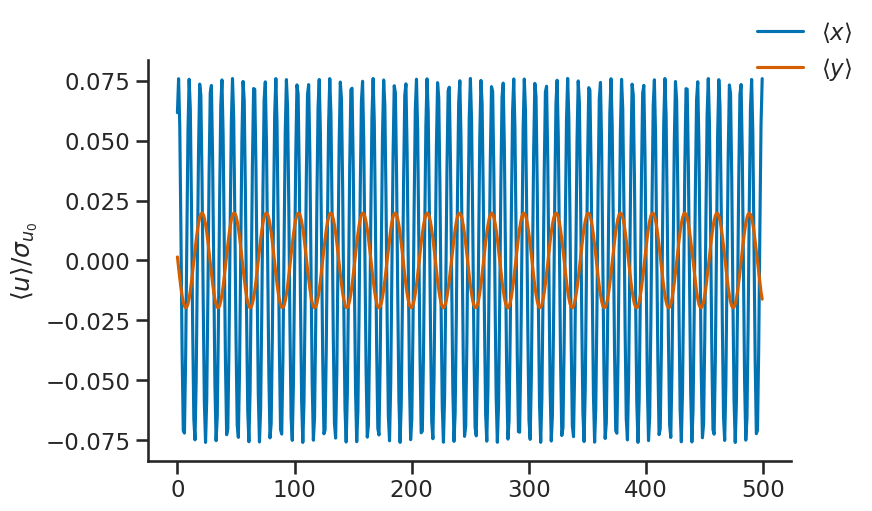

In [59]:
sbs.set(rc={'figure.figsize':(8.3,5.2)},
        style='ticks',
        palette='colorblind',
        context='talk',)
fig, ax = plt.subplots(1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.plot(mean_x/sigma_x[0], color='b', label='$\langle x \\rangle$')
ax.plot(mean_y/sigma_y[0], color='r', label='$\langle y \\rangle$')
ax.set_ylabel('$\langle u \\rangle/\sigma_{u_0}$')
# ax.set_ylim(-.5, .5)
plt.figlegend(frameon=False)

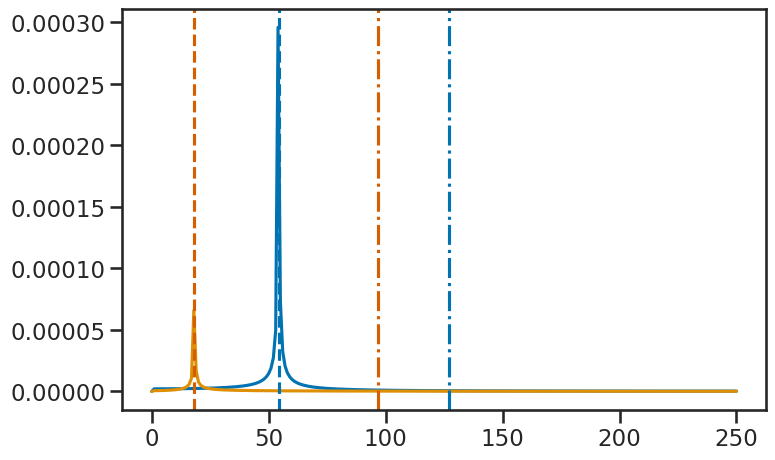

In [60]:
from numpy.fft import rfft, rfftfreq
from scipy.constants import c
from SOLEILII_parameters import SOLEILII_CDR_parameters
f_0 = c/CIRCUMFERENCE
f_s = f_0*500
fft_mean_x = np.abs(rfft(mean_x-np.mean(mean_x)))
fft_mean_y = np.abs(rfft(mean_y-np.mean(mean_y)))

fftfreq_mean_x = f_s*rfftfreq(mean_x.shape[0])/f_0
fftfreq_mean_y = f_s*rfftfreq(mean_y.shape[0])/f_0

fig, ax = plt.subplots(1, 1)
ax.plot(fftfreq_mean_x, fft_mean_x)
ax.plot(fftfreq_mean_y, fft_mean_y)
Q_X = 54.2
Q_Y = 18.2
ax.axvline(Q_X, color='b', linestyle='dashed')
ax.axvline(Q_Y, color='r', linestyle='dashed')

omega_i_y = 5.14e8
omega_i_x = 6.76e8
ax.axvline(omega_i_x/f_0/2/pi, color='b', linestyle='dashdot')
ax.axvline(omega_i_y/f_0/2/pi, color='r', linestyle='dashdot')

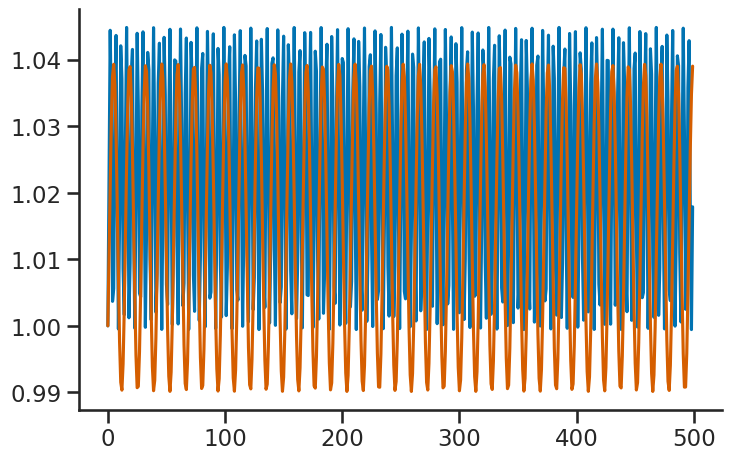

In [61]:
fig, ax = plt.subplots(1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.plot(sigma_x/sigma_x[0], color='b', label='$\sigma_x$')
ax.plot(sigma_y/sigma_y[0], color='r', label='$\sigma_y$')

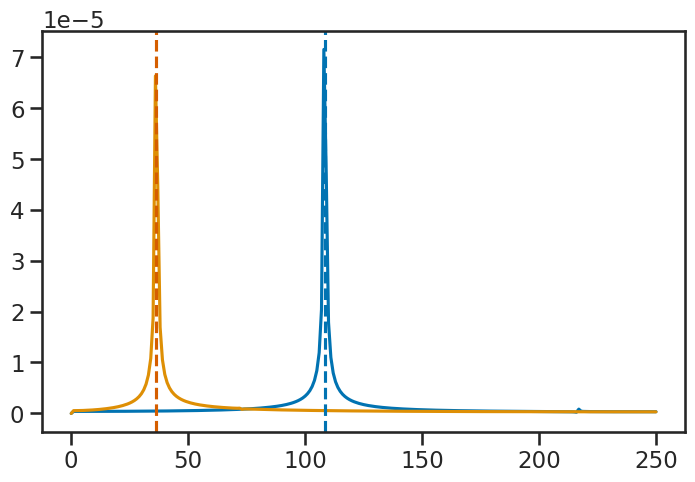

In [62]:
from numpy.fft import rfft, rfftfreq
from scipy.constants import c
CIRCUMFERENCE = 354
f_0 = c/CIRCUMFERENCE
f_s = f_0*500
fft_sigma_x = np.abs(rfft(sigma_x-np.mean(sigma_x)))
fft_sigma_y = np.abs(rfft(sigma_y-np.mean(sigma_y)))

fftfreq_sigma_x = f_s*rfftfreq(sigma_x.shape[0])/f_0
fftfreq_sigma_y = f_s*rfftfreq(sigma_y.shape[0])/f_0

fig, ax = plt.subplots(1, 1)
ax.plot(fftfreq_sigma_x, fft_sigma_x)
ax.plot(fftfreq_sigma_y, fft_sigma_y)
Q_X = 54.2
Q_Y = 18.2
ax.axvline(Q_X*2, color='b', linestyle='dashed')
ax.axvline(Q_Y*2, color='r', linestyle='dashed')           